In [1]:
# Import Dependencies
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

In [2]:
# Import haul cycle info

haul_csv = "Resources\CycleTime.csv"
haul_prfl_xlsx = "Resources\Haul_data.xlsx"
efh_data = "Resources\ProductionMetrics_X.xls"

cycles_df = pd.read_csv(haul_csv)
haul_profile_df = pd.read_excel(haul_prfl_xlsx)
efh_df = pd.read_excel(efh_data)

In [3]:
# Create wt items for each haul View cycles_df
cycles_df["Dist_wt"] = cycles_df["CycleDist"]*cycles_df["Loads"]
cycles_df["haul_full_wt"] = cycles_df["AvgFullHaul"]*cycles_df["Loads"]
cycles_df["haul_empty_wt"] = cycles_df["AvgEmptyHaul"]*cycles_df["Loads"]

cycles_df.head()

,Date,Truck,Shovel,LoadLocation,DumpLocationAdjusted,MaterialType,AvgFullHaul,AvgTimeForDump,AvgEmptyHaul,AvgSpotQueue,AvgTimeLoading,Loads,CycleDist,AvgTimeCycle,Dist_wt,haul_full_wt,haul_empty_wt
0,1/1/2020,T315,L530,MIP-X__01,CRUSHER 1,O-ARG,14.000000,5.216667,4.772222,5.088889,5.138889,3,4.0,34.216666,12.0,42.000000,14.316666
1,1/1/2020,T315,L530,X-BENCH-1,CRUSHER 1,O-ARG,14.016667,3.472222,11.861111,0.138889,2.105555,3,4.2,31.594444,12.6,42.050000,35.583333
2,1/1/2020,T315,L530,X-BENCH-1,CRUSHER 1,O-ARG,9.325000,4.608333,4.433333,5.258333,10.233333,2,4.4,33.858332,8.8,18.650000,8.866666
3,1/1/2020,T315,L530,X-BENCH-1,CRUSHER 3,O-ARG,17.683333,2.733333,29.283333,0.000000,8.183333,1,5.1,57.883332,5.1,17.683333,29.283333
4,1/1/2020,T315,L530,X-BENCH-1,CRUSHER 3,O-ARG,19.261111,2.238889,7.466667,1.027778,3.761111,3,5.1,33.755555,15.3,57.783333,22.400000


In [4]:
cycles_df['Date']=pd.to_datetime(cycles_df['Date'])

In [5]:
# Create new data frame to hold groupby cycle times and distances by day

cycles_daily_df = cycles_df.groupby(["Date"]).sum()

cycles_daily_df.reset_index(inplace=True)

cycles_daily_df.drop(columns = ['AvgTimeForDump', 'AvgSpotQueue', 'AvgTimeLoading', 'AvgTimeCycle'], axis=1, inplace=True)

cycles_daily_df['AvgFullHaul'] = cycles_daily_df['haul_full_wt']/cycles_daily_df['Loads']
cycles_daily_df['AvgEmptyHaul'] = cycles_daily_df['haul_empty_wt']/cycles_daily_df['Loads']
cycles_daily_df['CycleDist'] = cycles_daily_df['Dist_wt']/cycles_daily_df['Loads']

cycles_daily_df.head()

,Date,AvgFullHaul,AvgEmptyHaul,Loads,CycleDist,Dist_wt,haul_full_wt,haul_empty_wt
0,2020-01-01,17.768874,11.325783,234,6.310256,1476.6,4157.916627,2650.233288
1,2020-01-02,12.818046,9.376123,423,5.154610,2180.4,5422.033285,3966.099954
2,2020-01-03,11.585672,9.579532,456,4.450877,2029.6,5283.066607,4368.266610
3,2020-01-04,12.494832,10.336354,458,4.672926,2140.2,5722.633267,4734.049940
4,2020-01-05,13.814062,9.117225,448,5.283259,2366.9,6188.699933,4084.516608


In [6]:
efh_df.columns

Index(['Day', 'Shift', 'Ore Tons', 'Waste Tons', 'Stockpile Tons',
       'Total Tons', 'Eq. Trucks', 'Tons Per Ready Hour',
       'Tons Per Ready+Delay Hour', 'Ton-Mile per Ready Hour',
       'Tons Per Eq. Truck ', 'Truck Availability', 'Trucks Delayed',
       'Shift EFH'],
      dtype='object')

In [7]:
efh_clean_df = efh_df.drop(columns = ['Tons Per Ready Hour',
       'Tons Per Ready+Delay Hour', 'Ton-Mile per Ready Hour',
       'Tons Per Eq. Truck ', 'Truck Availability', 'Trucks Delayed'],axis=1)

efh_clean_df["EFH_Wt"] = efh_clean_df["Shift EFH"]*efh_clean_df["Total Tons"]
efh_clean_df["Trucks_Wt"] = efh_clean_df["Eq. Trucks"]*efh_clean_df["Total Tons"]

efh_clean_df.head()

,Day,Shift,Ore Tons,Waste Tons,Stockpile Tons,Total Tons,Eq. Trucks,Shift EFH,EFH_Wt,Trucks_Wt
0,2017-01-01,Night,32550.0,45880.0,0.0,78430.0,14.785399,5.382266,422131.12238,1.159619e+06
1,2017-01-01,Day,18600.0,57040.0,0.0,75640.0,12.174056,4.316008,326462.84512,9.208456e+05
2,2017-01-02,Night,40300.0,28210.0,0.0,68510.0,14.337518,5.086523,348477.69073,9.822634e+05
3,2017-01-02,Day,35960.0,35960.0,0.0,71920.0,13.148319,5.615079,403836.48168,9.456271e+05
4,2017-01-03,Night,26970.0,42470.0,0.0,69440.0,14.580826,5.350632,371547.88608,1.012493e+06


In [8]:
efh_daily_df = efh_clean_df.groupby(["Day"]).sum()

efh_daily_df.reset_index(inplace=True)

efh_daily_df['EFH'] = efh_clean_df["EFH_Wt"]/efh_clean_df["Total Tons"]
efh_daily_df['Trucks'] = efh_clean_df["Trucks_Wt"]/efh_clean_df["Total Tons"]

efh_daily_df.head()

,Day,Ore Tons,Waste Tons,Stockpile Tons,Total Tons,Eq. Trucks,Shift EFH,EFH_Wt,Trucks_Wt,EFH,Trucks
0,2017-01-01,51150.0,102920.0,0.0,154070.0,26.959455,9.698274,748593.96750,2.080464e+06,5.382266,14.785399
1,2017-01-02,76260.0,64170.0,0.0,140430.0,27.485837,10.701602,752314.17241,1.927890e+06,4.316008,12.174056
2,2017-01-03,46500.0,84630.0,0.0,131130.0,27.677879,10.422587,684436.79003,1.820450e+06,5.086523,14.337518
3,2017-01-04,62000.0,78120.0,0.0,140120.0,25.661160,8.927303,622198.01966,1.792612e+06,5.615079,13.148319
4,2017-01-05,67890.0,79360.0,0.0,147250.0,27.241600,8.650157,631898.51641,2.026351e+06,5.350632,14.580826


In [9]:
Haul_Cycle_model = pd.merge(cycles_daily_df,efh_daily_df, how="inner", left_on = "Date", right_on="Day")

Haul_Cycle_model.head()

,Date,AvgFullHaul,AvgEmptyHaul,Loads,CycleDist,Dist_wt,haul_full_wt,haul_empty_wt,Day,Ore Tons,Waste Tons,Stockpile Tons,Total Tons,Eq. Trucks,Shift EFH,EFH_Wt,Trucks_Wt,EFH,Trucks
0,2020-01-01,17.768874,11.325783,234,6.310256,1476.6,4157.916627,2650.233288,2020-01-01,70679.9125,29139.9125,0.0,99819.825,19.768835,11.307607,563256.045911,1.018541e+06,4.255798,17.319198
1,2020-01-02,12.818046,9.376123,423,5.154610,2180.4,5422.033285,3966.099954,2020-01-02,72229.9125,42159.9125,0.0,114389.825,22.002711,10.446407,600724.424142,1.291358e+06,4.562508,14.813358
2,2020-01-03,11.585672,9.579532,456,4.450877,2029.6,5283.066607,4368.266610,2020-01-03,68200.0000,27590.0000,0.0,95790.000,17.737388,9.671420,463316.189430,8.509527e+05,4.430942,15.177027
3,2020-01-04,12.494832,10.336354,458,4.672926,2140.2,5722.633267,4734.049940,2020-01-04,64170.0000,69439.8250,0.0,133609.825,24.187879,10.234775,689367.271398,1.653896e+06,3.996444,13.223978
4,2020-01-05,13.814062,9.117225,448,5.283259,2366.9,6188.699933,4084.516608,2020-01-05,27590.0000,99510.0000,0.0,127100.000,22.812530,8.347727,529928.259690,1.448318e+06,3.971207,16.557725


In [10]:
Haul_Cycle_model.columns

Index(['Date', 'AvgFullHaul', 'AvgEmptyHaul', 'Loads', 'CycleDist', 'Dist_wt',
       'haul_full_wt', 'haul_empty_wt', 'Day', 'Ore Tons', 'Waste Tons',
       'Stockpile Tons', 'Total Tons', 'Eq. Trucks', 'Shift EFH', 'EFH_Wt',
       'Trucks_Wt', 'EFH', 'Trucks'],
      dtype='object')

In [11]:
Haul_Cycle_model.drop(columns = ['Dist_wt','haul_full_wt', 'haul_empty_wt', 'Day','Eq. Trucks', 'Shift EFH', 'EFH_Wt',
                                 'Trucks_Wt'],inplace=True)

Haul_Cycle_model.dropna(inplace=True)

Haul_Cycle_model = Haul_Cycle_model[Haul_Cycle_model['CycleDist']<7]

In [12]:
Haul_Cycle_model["Cycle_Time"] = Haul_Cycle_model['AvgFullHaul']+Haul_Cycle_model['AvgEmptyHaul']

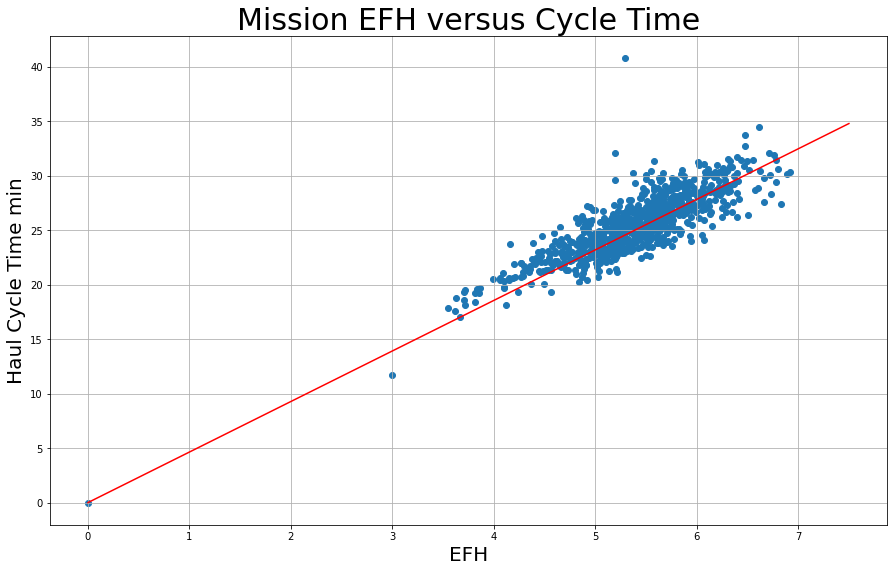

In [13]:
Haul_Time = Haul_Cycle_model["Cycle_Time"]
EFH = Haul_Cycle_model['CycleDist']
x = [0,7.5]
y = [0,34.768]
plt.subplots(figsize=(15, 9))
plt.scatter(EFH, Haul_Time)
plt.plot(x,y, c= "red")
plt.title("Mission EFH versus Cycle Time", fontsize=30)
plt.ylabel("Haul Cycle Time min", fontsize=20)
plt.xlabel("EFH", fontsize=20)
plt.grid(True)

In [14]:
# Set variables for Regression

X = Haul_Cycle_model[['CycleDist']]
y = Haul_Cycle_model[["Cycle_Time"]]


# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Fit model
model = LinearRegression(fit_intercept=False)

# Learning stage
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

In [15]:
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")
print(f"Model Score = {model.score(X,y)}")

Training Score: 0.7010941271184535
Testing Score: 0.6580460797963574
Model Score = 0.6926856750048511


In [16]:
print(model.coef_)


[[4.72612233]]


In [17]:
# Create list of unique dump locations 
cycles_df['DumpLocationAdjusted'].unique()

array(['CRUSHER 1', 'CRUSHER 3', '24F', '24N DUMP', '3240SOUTHEASTDUMP',
       nan, '24Q DUMP', '24E', '3240SOUTHEASTEDUMP',
       'AREA 51 ROAD MATERIAL', '3240SHOUTHEASTDUMP',
       'U-BENCH HGW STKPILE', '24ZB', '3400 STEMMING STOCKPILE',
       'MIP-X__02', '3270 EAST DUMP', '3500 EAST DUMP', '3270EASTDUMP',
       '3170 LOWER EAST DUMP', '24N', '3270 WEST DUMP', '3600 DUMP',
       '3380 SWE DUMP', 'CR3 HAULBACK', '24EDUMP', '3270WESTDUMP',
       'INVTEST', '3330WTHILLDUMP', 'CRUSHER3', '3330 WT HILL DUMP',
       '3400-WT HILL DUMP', '3400WTHILLDUMP', '3430-WT-HILL-DUMP',
       '3442-WT-HILL-DUMP', '3442WTHILLDUMP', '3550 EAST DUMP',
       '3270WEST DUMP', 'MIP-ZA__01', '3650 EAST PIMA', '24N DUMP SOUTH',
       'MIP-N__01', '3240 ASHTON ROCK', '3330 ORE STOCKPILE1',
       '3240 SOUTH EAST DUMP', '3240 DUMP ON TOP', 'A BENCH CAP',
       '3650 DUMP ON TOP', 'CR3_MAYHEM_DUMP', '3640 S PIMA',
       'A2_DUMPED_MATERIAL', '3650DUMP ON TOP', 'MIP-ZC__02',
       'MAYHEM_DUMP',

In [26]:
#  Create Dumps and queue df

dq_df = cycles_df.drop(columns = ['Truck', 'Shovel', 'LoadLocation','MaterialType', 'AvgFullHaul','AvgEmptyHaul','AvgTimeLoading',
                                 'CycleDist', 'AvgTimeCycle','Dist_wt', 'haul_full_wt', 'haul_empty_wt'], axis=1)

dq_df.dropna(inplace=True)

dq_df['dmp_wt'] = dq_df['AvgTimeForDump'] * dq_df['Loads']
dq_df['que_wt'] = dq_df['AvgSpotQueue'] * dq_df['Loads']

# Ore dumps
ore_dmps=['CRUSHER 1', 'CRUSHER 3','CRUSHER3','CR3 HAULBACK']

ore_dumps = dq_df[dq_df['DumpLocationAdjusted'].isin(ore_dmps)]

waste_dumps = dq_df[~dq_df['DumpLocationAdjusted'].isin(ore_dmps)]

In [29]:
# Average queue and dump times by location

dump_time_crusher = ore_dumps.groupby(by='DumpLocationAdjusted', as_index=False).sum()
dump_time_crusher['AvgTimeForDump'] = dump_time_crusher['dmp_wt']/dump_time_crusher['Loads']
dump_time_crusher['AvgSpotQueue'] = dump_time_crusher['que_wt']/dump_time_crusher['Loads']


dump_time = waste_dumps.groupby(by='DumpLocationAdjusted', as_index=False).sum()
dump_time['AvgTimeForDump'] = dump_time['dmp_wt']/dump_time['Loads']
dump_time['AvgSpotQueue'] = dump_time['que_wt']/dump_time['Loads']

In [30]:
# Review Crusher dump and spot performance
dump_time_crusher

,DumpLocationAdjusted,AvgTimeForDump,AvgSpotQueue,Loads,dmp_wt,que_wt
0,CR3 HAULBACK,0.366666,0.883333,1,0.366666,0.883333
1,CRUSHER 1,5.140075,3.241451,74528,383079.519739,241578.870357
2,CRUSHER 3,3.198721,3.235033,71641,229159.536403,231761.020111


In [39]:
# Review other dump and spot performance
dump_time = dump_time[dump_time['AvgTimeForDump']>.5]

average_dump_time = dump_time['dmp_wt'].sum() / dump_time['Loads'].sum()
average_queue_time = dump_time['que_wt'].sum() / dump_time['Loads'].sum()

print(f'The average dump time is {average_dump_time}')
print(f'The average queue time is {average_queue_time}')

The average dump time is 1.061654846665929
The average queue time is 3.1973898692973535
